In [1]:
from siepic import all as pdk
from ipkiss3 import all as i3
from ipkiss3 import constants
from ipkiss.process.layer_map import GenericGdsiiPPLayerOutputMap
from mzi_pcell_yb_thermo import MZI_YB_thermo, pplayer_map
from datetime import datetime
import numpy as np
import pylab as plt
from pysics.basics.material.material_stack import MaterialStack
from ipkiss.visualisation.display_style import DisplayStyle
from ipkiss.visualisation import color
from bond_pads import pplayer_m1, pplayer_m2, pplayer_m_open

In [2]:
# Parameters for the thermo-optic MZI Y-branch sweep
parameters = [20.0, 50.0]
bend_radius = 5.0
x0 = 5.0
y0 = 2.5
x_spacing = 10
y_spacing = 10

In [3]:
# Material visualization definitions for virtual fabrication compliant with the materials stack colors
i3.TECH.MATERIALS.SILICON_OXIDE.display_style = DisplayStyle(color=color.COLOR_BLUE)
i3.TECH.MATERIALS.SILICON.display_style = DisplayStyle(color=color.COLOR_RED)
i3.TECH.MATERIALS.TUNGSTEN.display_style = DisplayStyle(color=color.COLOR_YELLOW)
i3.TECH.MATERIALS.ALUMINIUM.display_style = DisplayStyle(color=color.COLOR_GRAY)

In [4]:
# Material stack definitions for virtual fabrication 
# Only oxide layer / passivated (last silica layer)
MSTACK_SOI_OX = MaterialStack(
    name="Oxide",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        # (TECH.MATERIALS.SILICON_OXIDE, 0.22),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 0.3),  # passivation layer
    ],
    display_style=DisplayStyle(color=color.COLOR_BLUE),
)

In [5]:
# Only oxide layer / passivated (last silica layer)
MSTACK_SOI_OX = MaterialStack(
    name="Oxide",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        # (TECH.MATERIALS.SILICON_OXIDE, 0.22),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 0.3),  # passivation layer
    ],
    display_style=DisplayStyle(color=color.COLOR_BLUE),
)

# Waveguide surrounded by oxide / passivated
MSTACK_SOI_220nm_OX = MaterialStack(
    name="220nm Si + Oxide",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        (i3.TECH.MATERIALS.SILICON, 0.220),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 0.3),  # passivation layer
    ],
    display_style=DisplayStyle(color=color.COLOR_RED),
)

# Waveguide with the heater without the routing metal / passivated
MSTACK_SOI_220nm_OX_METAL_H = MaterialStack(
    name="220nm Si + Oxide + Heater",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        (i3.TECH.MATERIALS.SILICON, 0.220),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.TUNGSTEN, 0.2),  # The heater (actually titanium + tungsten alloy)
        (i3.TECH.MATERIALS.SILICON_OXIDE, 0.3),  # passivation layer
    ],
    display_style=DisplayStyle(color=color.COLOR_YELLOW),
)

# Oxide with heater with the routing metal (no waveguide) / passivated
MSTACK_SOI_OX_METAL_H_R_p = MaterialStack(
    name="Oxide + Heater + routing",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        # (i3.TECH.MATERIALS.SILICON, 0.220),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.TUNGSTEN, 0.2),  # The heater (actually titanium + tungsten alloy)
        (i3.TECH.MATERIALS.ALUMINIUM, 0.5),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 0.3),  # passivation layer
    ],
    display_style=DisplayStyle(color=color.COLOR_GRAY),
)

# Waveguide with the heater and with the routing metal / passivated
MSTACK_SOI_220nm_OX_METAL_H_R_p = MaterialStack(
    name="220nm Si + Oxide + Heater + routing",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        (i3.TECH.MATERIALS.SILICON, 0.220),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.TUNGSTEN, 0.2),  # The heater (actually titanium + tungsten alloy)
        (i3.TECH.MATERIALS.ALUMINIUM, 0.5),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 0.3),  # passivation layer
    ],
    display_style=DisplayStyle(color=color.COLOR_GREEN),
)

# Oxide with the heater and with the routing metal (no waveguide) and with the passivation layer removed
MSTACK_SOI_OX_METAL_H_R = MaterialStack(
    name="Oxide + Heater + routing + bond pad open",
    materials_heights=[
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.0),
        # (TECH.MATERIALS.SILICON, 0.220),
        (i3.TECH.MATERIALS.SILICON_OXIDE, 2.2),
        (i3.TECH.MATERIALS.TUNGSTEN, 0.2),  # The heater (actually titanium + tungsten alloy)
        (i3.TECH.MATERIALS.ALUMINIUM, 0.5),
    ],
    display_style=DisplayStyle(color=color.COLOR_BLUE_VIOLET),
)

In [6]:
# Compose a process flow (maps layers to processes)

i3.TECH.VFABRICATION.overwrite_allowed.append("PROCESS_FLOW")
PROCESS_FLOW = i3.VFabricationProcessFlow(
    active_processes=[i3.TECH.PROCESS.WG, i3.TECH.PROCESS.M1, i3.TECH.PROCESS.M2, i3.TECH.PROCESS.M_open],
    process_layer_map={
        i3.TECH.PROCESS.WG: i3.TECH.PPLAYER.WG,
        i3.TECH.PROCESS.M1: pplayer_m1,
        i3.TECH.PROCESS.M2: pplayer_m2,
        i3.TECH.PROCESS.M_open: pplayer_m_open,
    },
    process_to_material_stack_map=[
        ((0, 0, 0, 0), MSTACK_SOI_OX),  # Background
        ((1, 0, 0, 0), MSTACK_SOI_220nm_OX),  # Only silicon waveguide
        ((0, 1, 1, 0), MSTACK_SOI_OX_METAL_H_R_p),  # Bilayer routing when M1 and M2 are present at the same time
        ((0, 0, 1, 0), MSTACK_SOI_OX_METAL_H_R_p),  # Bilayer routing when only M2 layer is present
        ((0, 0, 1, 1), MSTACK_SOI_OX_METAL_H_R),  # Bond pad open
        ((1, 1, 1, 0), MSTACK_SOI_220nm_OX_METAL_H_R_p),  # Waveguide with the heater + electrical connection
        ((1, 1, 0, 0), MSTACK_SOI_220nm_OX_METAL_H),  # Waveguide with the heater only
    ],
    is_lf_fabrication={  # Is light-field fabrication? Processes areas remain with this and the process layer map
        i3.TECH.PROCESS.WG: False,
        i3.TECH.PROCESS.M1: False,
        i3.TECH.PROCESS.M2: False,
        i3.TECH.PROCESS.M_open: False,
    },
)

In [7]:
# Write the content to be written on WG_P6NM on Silicon layer directly
pplayer_map[i3.TECH.PROCESS.WG_P6NM, i3.TECH.PURPOSE.DRAWING] = pplayer_map[i3.TECH.PROCESS.WG, i3.TECH.PURPOSE.DRAWING]
output_layer_map = GenericGdsiiPPLayerOutputMap(pplayer_map=pplayer_map)

In [8]:
insts = dict()
specs = []

# Create the floor plan for EdX design area
floorplan = pdk.FloorPlan(name="FLOORPLAN", size=(440.0, 470.0))

# Add the floor plan to the instances dict and place it at (0.0, 0.0)
insts["floorplan"] = floorplan
specs.append(i3.Place("floorplan", (0.0, 0.0)))

# Initialize the text label dictionary
text_label_dict = {}  # Text labels dictionary for automated measurement labels
circuit_cell_names = []  # Constituent circuit cell names list

In [9]:
# Create the MZI sweep for MZIs with Y-branches
for ind, parameter in enumerate(parameters, start=1):
    # Instantiate the MZI
    mzi_thermo = MZI_YB_thermo(
        name="MZI_thermo{}".format(ind),
        bend_radius=bend_radius,
        arm_spacing=parameter,
        second_heater=True,
    )

    # Add the MZI to the instances dict and place it
    mzi_cell_name = "MZIheater{}".format(ind)
    insts[mzi_cell_name] = mzi_thermo
    size_info = mzi_thermo.Layout().size_info()
    x_pos = x0 + abs(size_info.west)
    y_pos = y0 + abs(size_info.south)
    specs.append(i3.Place(mzi_cell_name, (x_pos, y_pos)))

    # Put the measurement label for optical measurements
    meas_label = f"{mzi_thermo.measurement_label_pretext}{mzi_cell_name}"
    meas_label_coord = mzi_thermo.measurement_label_position + (x_pos, y_pos)
    text_label_dict[mzi_cell_name] = [meas_label, meas_label_coord]
    circuit_cell_names.append(mzi_cell_name)

    # Put the measurement label for electrical measurements
    meas_label = f"{mzi_thermo.bond_pad2.measurement_label_pretext}{mzi_cell_name}_G"
    meas_label_coord = mzi_thermo.elec_meas_label_position + (x_pos, y_pos)
    text_label_dict[f"{mzi_cell_name}_e"] = [meas_label, meas_label_coord]
    # Place the next circuit to the right of GDS layout
    y0 += 250  # This spacing is to stay compliant with the bondpad pitch
    

In [10]:
# Create the final design with i3.Circuit
top_cell = i3.Circuit(
    name=f"EBeam_OngunArisev_thermo_B_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}",
    insts=insts,
    specs=specs,
)

In [11]:
# Bigger visualization
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 100

In [12]:
# For the GDS text elements for automated measurement
text_elems = []
for key, value in text_label_dict.items():
    text_label = value[0]
    text_label_coord = value[1]
    text_elems += i3.Label(layer=i3.TECH.PPLAYER.TEXT, text=text_label,
                          coordinate=text_label_coord,
                          alignment=(constants.TEXT.ALIGN.LEFT, constants.TEXT.ALIGN.BOTTOM), height=2)

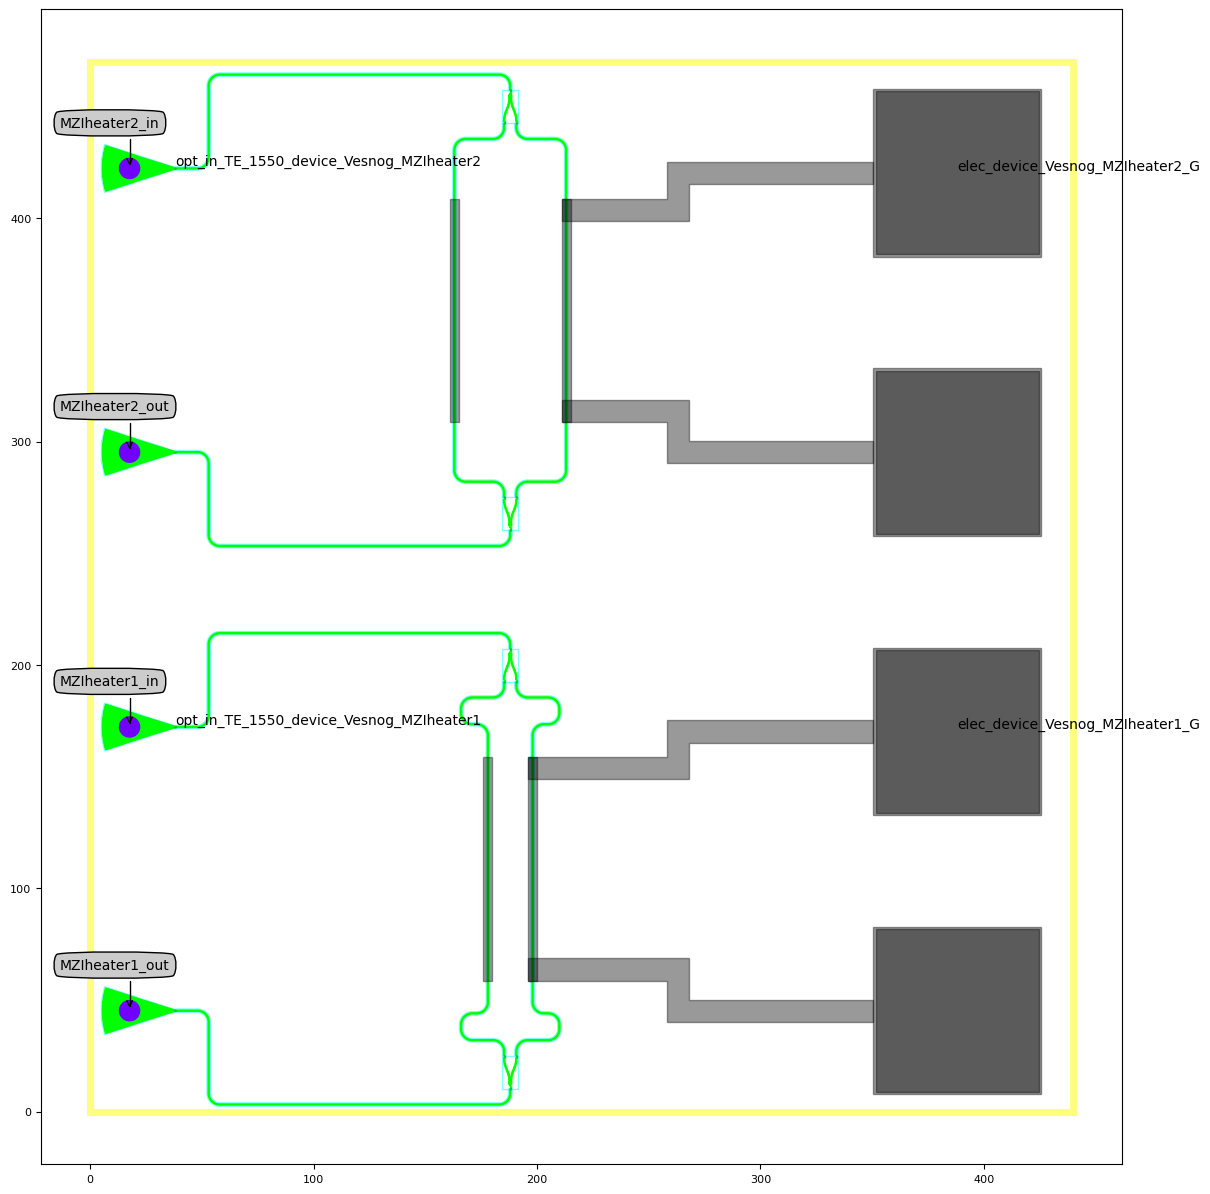

C:\Users\ongun\PycharmProjects\ipkiss_training\EBeam_heaters_Vesnog_B.gds

In [13]:
# Layout and GDS writing
filename = "EBeam_heaters_Vesnog_B.gds"
cell_lv = top_cell.Layout()
cell_lv.append(text_elems)
cell_lv.visualize(annotate=True)
cell_lv.write_gdsii(filename, layer_map=output_layer_map)
# This time we have a disconnected heater on the left arm as well

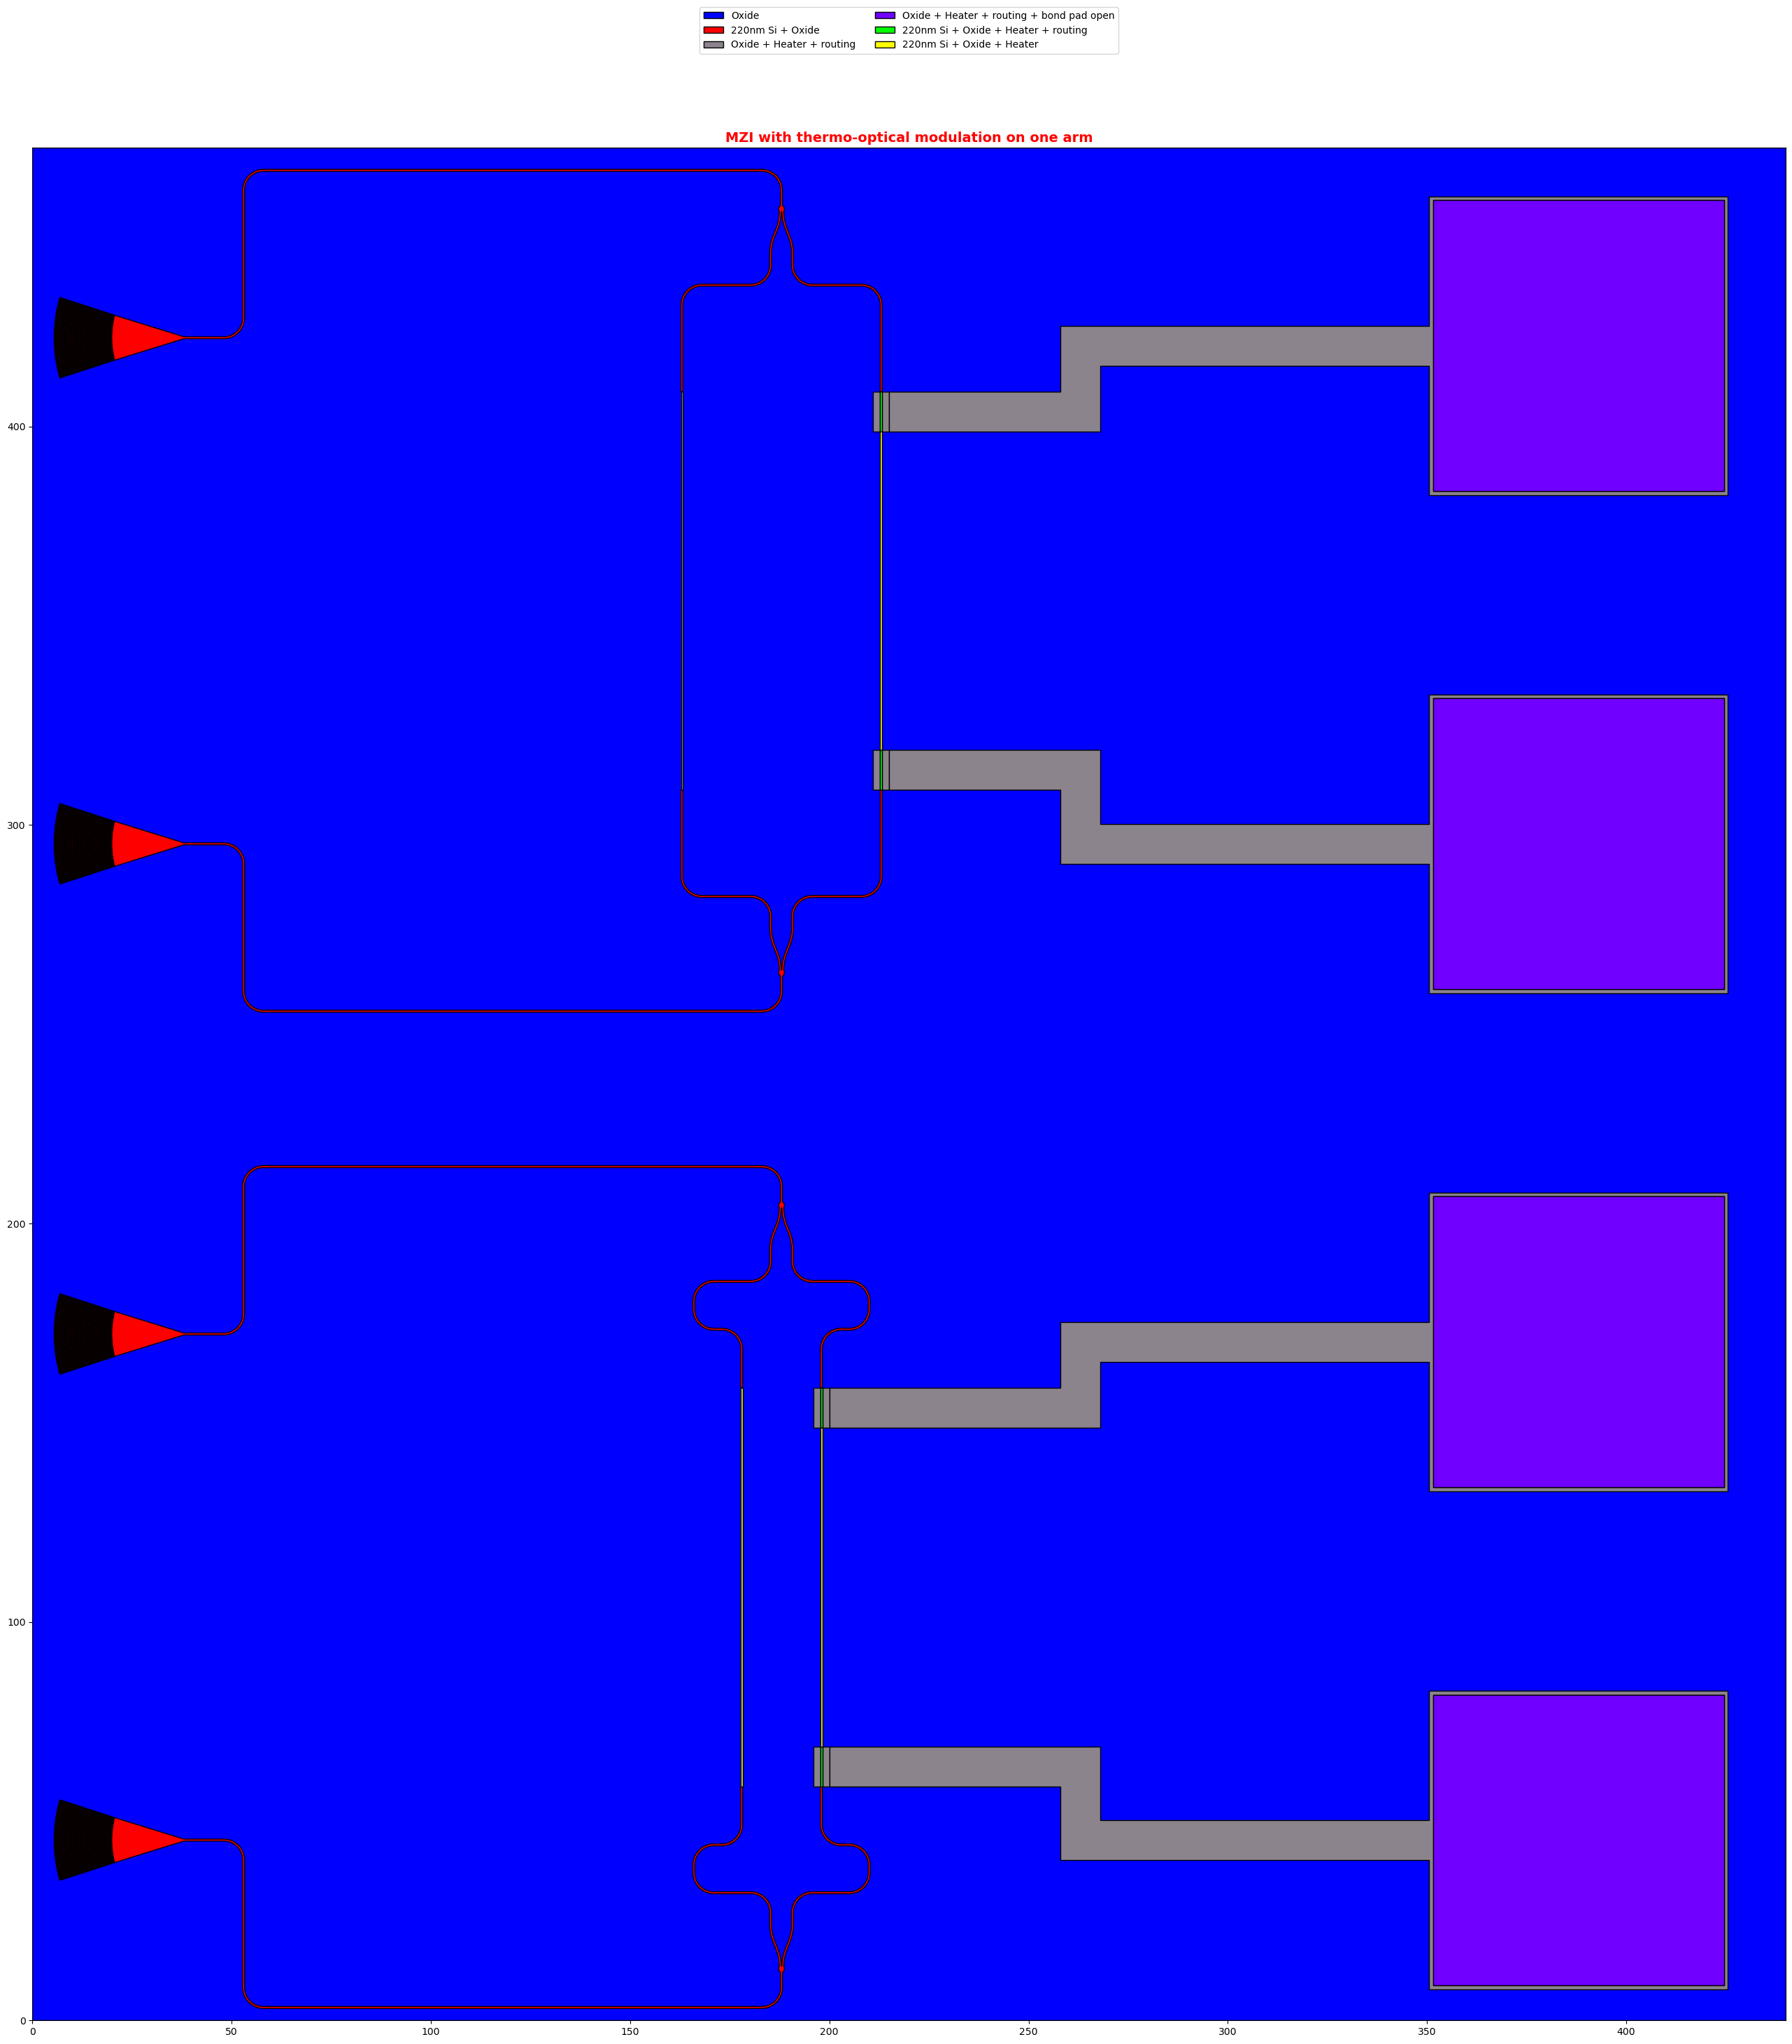

In [14]:
# Visualize the stacks in the final fabricated chip from top-down
plt.rcParams['figure.figsize'] = [35, 35]
f = cell_lv.visualize_2d(process_flow=PROCESS_FLOW, enter_mainloop=False)
ax = f.axes[0]
l = ax.get_legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height*0.9])
ax.set_title('MZI with thermo-optical modulation on one arm', fontdict={'fontsize': 14, 'fontweight':'bold', 'color': 'r'})
ax.legend(l.get_patches(), [t.get_text() for t in l.get_texts()], bbox_to_anchor=(0.5, 1.05), borderaxespad=0, loc=8, ncol=2)
plt.show()
# Double click on the notebook to zoom

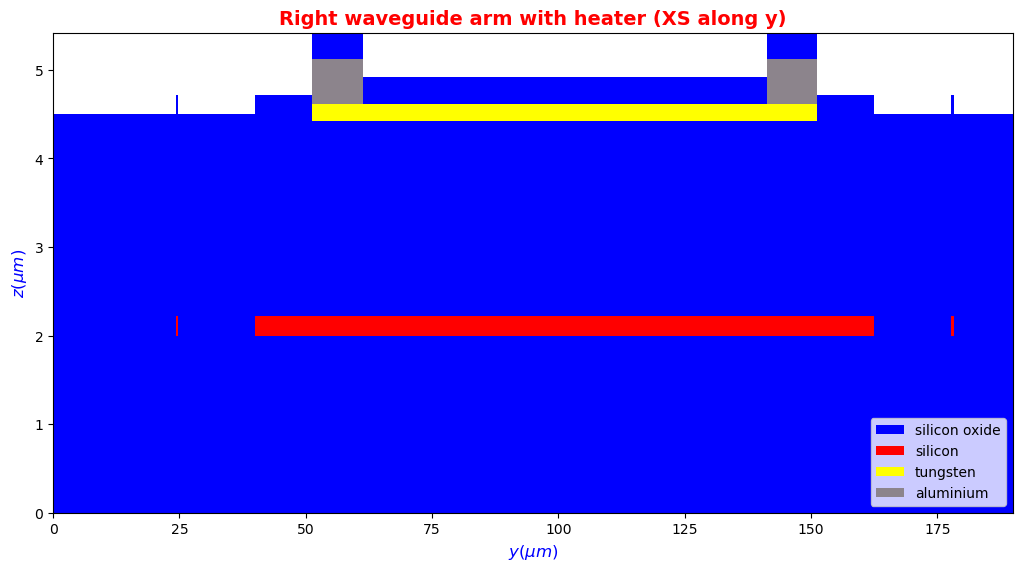

In [15]:
# Visualize the cross-section along the heated arm
plt.rcParams['figure.figsize'] = [12, 8]
f1 = cell_lv.cross_section(i3.Shape([(198, 210), (198, 20)]), process_flow=PROCESS_FLOW).visualize(show=False)
ax = f1.axes[0]
ax.set_xlabel("$y(\mu m)$", fontdict={'fontsize':12, 'fontweight':'bold', 'color':'b'})
ax.set_ylabel("$z(\mu m)$", fontdict={'fontsize':12, 'fontweight':'bold', 'color':'b'})
l = ax.get_legend()
l._set_loc(4)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_aspect((xmax-xmin)/(ymax-ymin)/2)
ax.set_title("Right waveguide arm with heater (XS along y)", fontdict={'fontsize': 14, 'fontweight':'bold', 'color': 'r'})
plt.show()

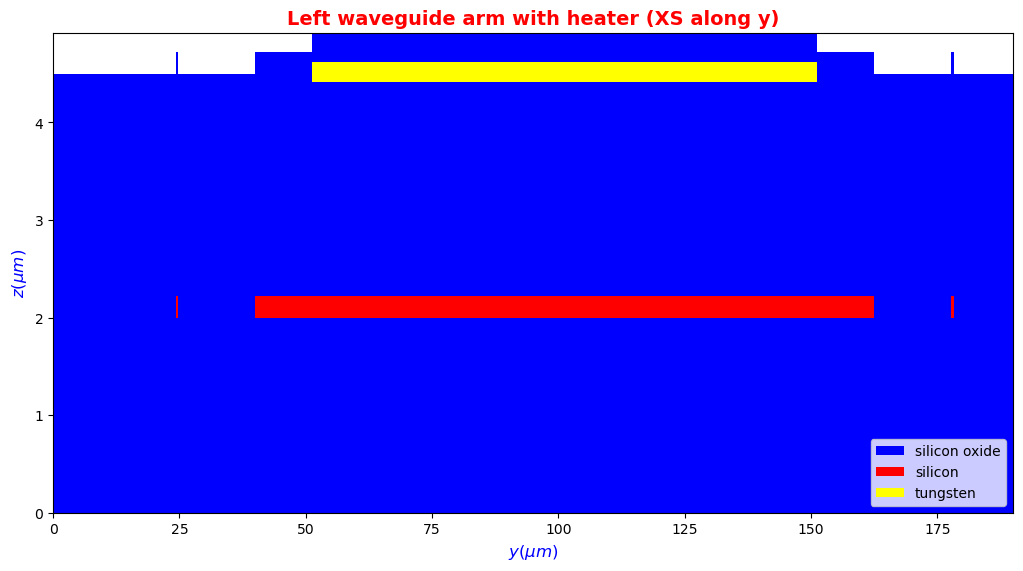

In [16]:
# Visualize the cross-section along the non-heated arm
f2 = cell_lv.cross_section(i3.Shape([(178, 210), (178, 20)]), process_flow=PROCESS_FLOW).visualize(show=False)
ax = f2.axes[0]
ax.set_xlabel("$y(\mu m)$", fontdict={'fontsize':12, 'fontweight':'bold', 'color':'b'})
ax.set_ylabel("$z(\mu m)$", fontdict={'fontsize':12, 'fontweight':'bold', 'color':'b'})
ax.set_title("Left waveguide arm with heater (XS along y)", fontdict={'fontsize': 14, 'fontweight':'bold', 'color': 'r'})
l = ax.get_legend()
l._set_loc(4)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_aspect((xmax-xmin)/(ymax-ymin)/2)

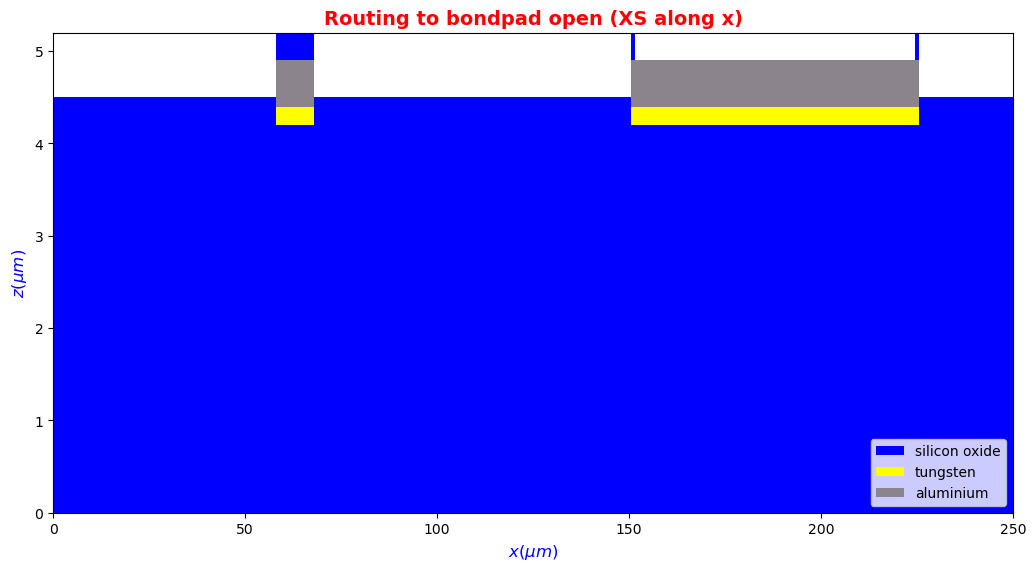

In [17]:
# Visualize the route to the bondpad open from the heater
f3 = cell_lv.cross_section(i3.Shape([(200, 160), (450, 160)]), process_flow=PROCESS_FLOW).visualize(show=False)
ax = f3.axes[0]
ax.set_xlabel("$x(\mu m)$", fontdict={'fontsize':12, 'fontweight':'bold', 'color':'b'})
ax.set_ylabel("$z(\mu m)$", fontdict={'fontsize':12, 'fontweight':'bold', 'color':'b'})
ax.set_title("Routing to bondpad open (XS along x)", fontdict={'fontsize': 14, 'fontweight':'bold', 'color': 'r'})
l = ax.get_legend()
l._set_loc(4)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_aspect((xmax-xmin)/(ymax-ymin)/2)
plt.show()

C:\ProgramData\Anaconda3\envs\ipkiss3\lib\site-packages\ipkiss3\simulation\engines\caphe_circuit_sim\caphenodegenerator.py:376: UserWarning: The following child nodes are not connected and will be removed:
floorplan
  warn(msg)


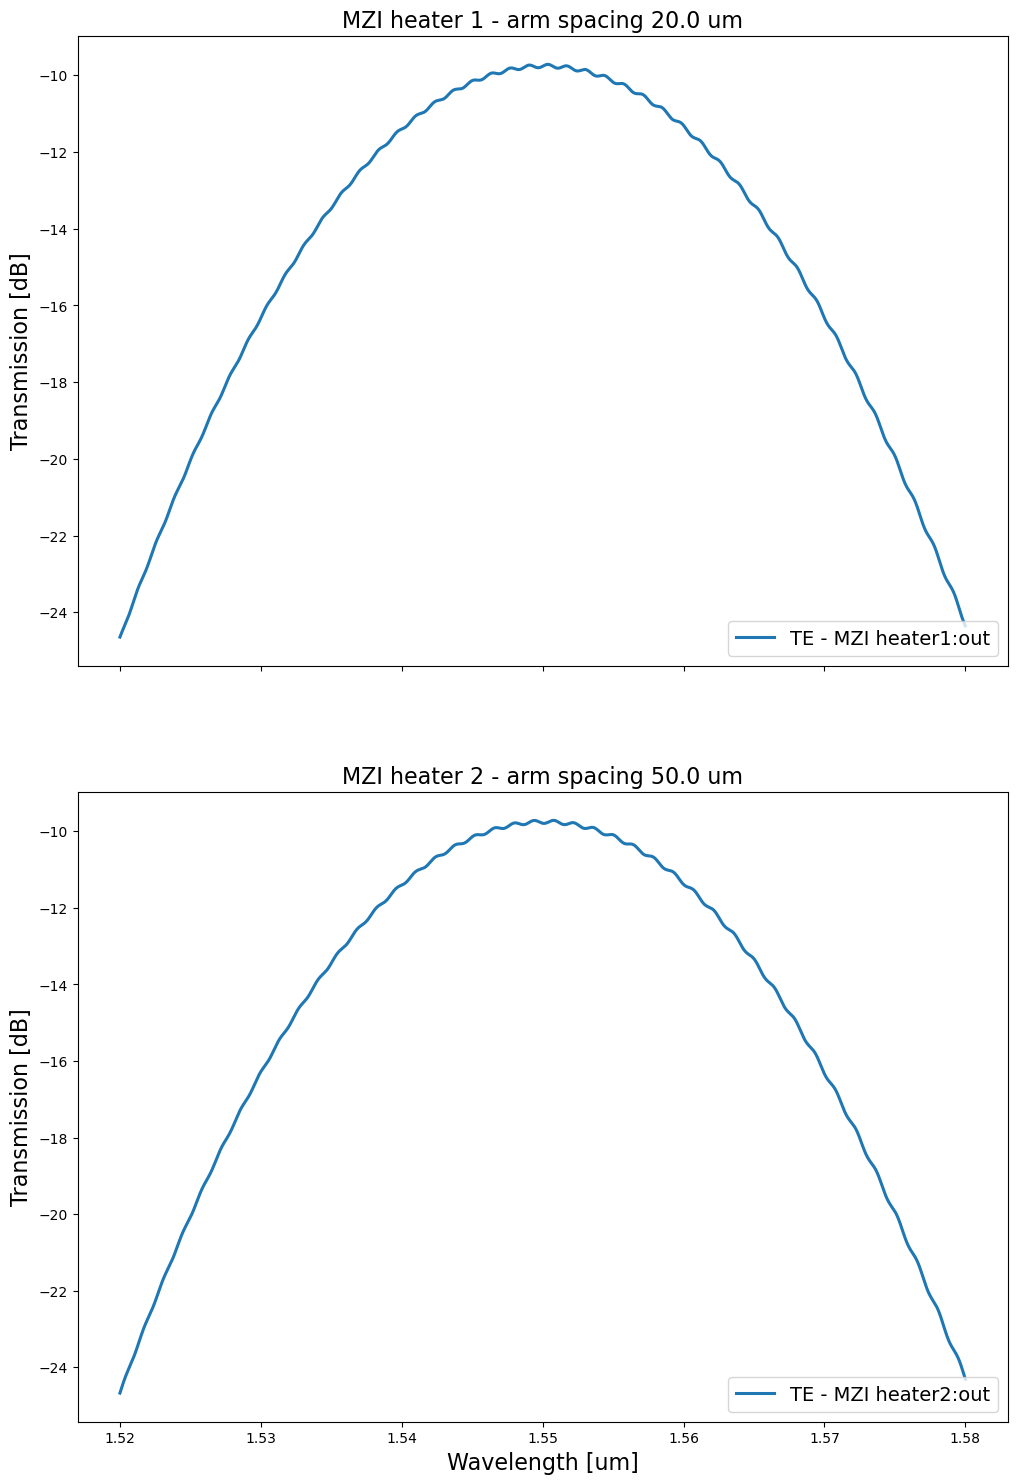

Done


In [18]:
# Circuit model
cell_cm = top_cell.CircuitModel()
wavelengths = np.linspace(1.52, 1.58, 4001)
S_total = cell_cm.get_smatrix(wavelengths=wavelengths)

# Plotting
fig, axs = plt.subplots(len(parameters), sharex="all", figsize=(12, 18))

for ind, parameter in enumerate(parameters, start=1):
    # After the colon the mode is selected (two modes) / for the particular examples S-matrix has 12x12x2 entries
    # not counting the ones due to wavelength
    tr_out1 = i3.signal_power_dB(S_total["MZIheater{}_out:0".format(ind), "MZIheater{}_in:0".format(ind)])

    # Indices of the axes will be zero based
    ax_idx = ind - 1
    axs[ax_idx].plot(wavelengths, tr_out1, "-", linewidth=2.2, label="TE - MZI heater{}:out".format(ind))

    axs[ax_idx].set_ylabel("Transmission [dB]", fontsize=16)
    axs[ax_idx].set_title("MZI heater {} - arm spacing {} um".format(ind, parameter), fontsize=16)
    axs[ax_idx].legend(fontsize=14, loc=4)

axs[-1].set_xlabel("Wavelength [um]", fontsize=16)
plt.show()

print("Done")